<a href="https://colab.research.google.com/github/Tuchsanai/AIMaster-seagate-training-2024/blob/main/Day3/02_Fine-Tuning%20Sentiment%20Custom%20Dataset/Fine-Tuning%20Sentiment%20Custom%20Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:


import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

# Run the installation commands
!pip install  datasets accelerate
# Clean up the notebook
clean_notebook()

Notebook cleaned.


In [13]:

# Corrected code to download the dataset
!wget -nc https://raw.githubusercontent.com/Tuchsanai/AIMaster-seagate-training-2024/db8331a3dc4845bb322d6f638f55095256799a70/Dataset/AirlineTweets.csv

File ‘AirlineTweets.csv’ already there; not retrieving.



In [14]:
import os
os.environ['HF_TOKEN'] ="your_hugging_face_token_here"

In [15]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split


In [16]:
df_ = pd.read_csv('./AirlineTweets.csv')
df = df_[['airline_sentiment', 'text']].copy()
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


<Axes: >

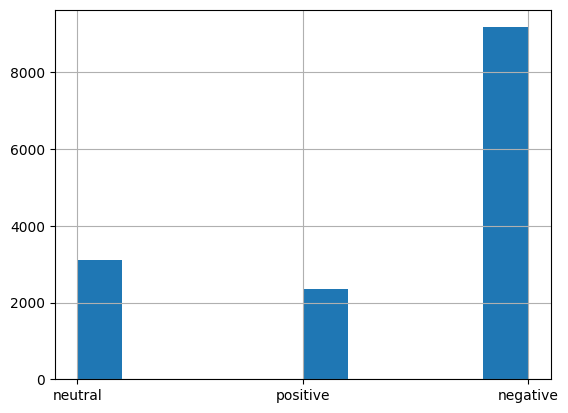

In [17]:
df['airline_sentiment'].hist()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


In [19]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)
df= df.drop('airline_sentiment',axis=1)
df.columns = ['sentence', 'label']
df.to_csv('data.csv', index=None)

df

,sentence,label
0,@VirginAmerica What @dhepburn said.,2
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,2
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0
...,...,...
14635,@AmericanAir thank you we got on a different f...,1
14636,@AmericanAir leaving over 20 minutes Late Flig...,0
14637,@AmericanAir Please bring American Airlines to...,2
14638,"@AmericanAir you have my money, you change my ...",0


load dataset to csv

In [20]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='data.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [21]:
# if you have multiple csv files
# load_dataset('csv', data_files=['file1.csv', 'file2.csv'])

In [22]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [23]:
raw_dataset['train'][0:5]

{'sentence': ['@VirginAmerica What @dhepburn said.',
  "@VirginAmerica plus you've added commercials to the experience... tacky.",
  "@VirginAmerica I didn't today... Must mean I need to take another trip!",
  '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
  "@VirginAmerica and it's a really big bad thing about it"],
 'label': [2, 1, 2, 0, 0]}

In [24]:
dataset = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

# Model

In [25]:
!pip install torchinfo

# https://huggingface.co/distilbert/distilbert-base-cased

In [26]:
from transformers import AutoTokenizer

checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [27]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], padding=True, truncation=True, return_tensors='pt')

tokenizer_dataset = dataset.map(tokenize_fn, batched = True)
tokenizer_dataset= tokenizer_dataset.remove_columns(['sentence'])

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [28]:
tokenizer_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 4392
    })
})

In [29]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [30]:
checkpoint = 'distilbert-base-cased'
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
model

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [31]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [32]:
from transformers import DataCollatorWithPadding
# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

training_args = TrainingArguments(
  output_dir='training_dir',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=8,
  per_device_train_batch_size=96,
  per_device_eval_batch_size=96,
  learning_rate=2e-5,
  weight_decay=0.01,
  logging_strategy="steps",
  logging_steps=100,  # Log every 10 steps
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenizer_dataset["train"],
    eval_dataset=tokenizer_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [34]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.644300,0.469041,0.810337,0.757742
2,0.411900,0.442785,0.825592,0.766420
3,0.349200,0.434180,0.836293,0.782388
4,0.288300,0.454700,0.839253,0.788689
5,0.243800,0.481162,0.839253,0.783340
6,0.187300,0.505248,0.833561,0.783591
7,0.171400,0.526012,0.834927,0.780892
8,0.143000,0.540874,0.834016,0.780690


TrainOutput(global_step=856, training_loss=0.2942260358935205, metrics={'train_runtime': 283.6471, 'train_samples_per_second': 289.035, 'train_steps_per_second': 3.018, 'total_flos': 1675725918233472.0, 'train_loss': 0.2942260358935205, 'epoch': 8.0})

# Create pipeline

In [35]:
!ls training_dir

checkpoint-107	checkpoint-321	checkpoint-535	checkpoint-749	runs
checkpoint-214	checkpoint-428	checkpoint-642	checkpoint-856


In [36]:
from transformers import pipeline

savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-856',
                      device=0)

savedmodel

In [37]:
test_pred = savedmodel(dataset['test']['sentence'])
test_pred[0:5]

[{'label': 'LABEL_1', 'score': 0.9699535965919495},
 {'label': 'LABEL_1', 'score': 0.9778558611869812},
 {'label': 'LABEL_1', 'score': 0.8270602822303772},
 {'label': 'LABEL_1', 'score': 0.8546661138534546},
 {'label': 'LABEL_2', 'score': 0.9583950042724609}]

In [38]:
def get_label(d):
  return int(d['label'].split('_')[1])

test_pred = [get_label(d) for d in test_pred]

In [39]:
print("acc:", accuracy_score(dataset['test']['label'], test_pred))

acc: 0.8340163934426229


In [40]:
print("f1:", f1_score(dataset['test']['label'], test_pred, average='macro'))

f1: 0.7806904068861525


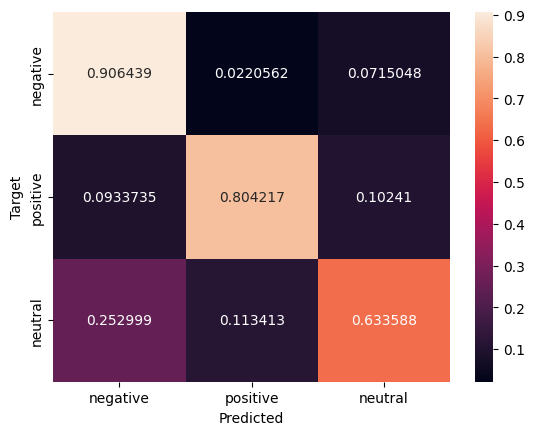

In [41]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['negative', 'positive', 'neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

cm = confusion_matrix(dataset['test']['label'], test_pred, normalize='true')
plot_cm(cm)